In [1]:
%load_ext autoreload

In [2]:
%load_ext jupyter_black

In [3]:
%autoreload 2

In [4]:
import os
import numpy as np
import torch

print(torch.__version__)

2.0.1+cu117


In [5]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# The GPU id to use, "0" to  "7"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [6]:
# Import Print function
from __future__ import print_function

In [7]:
torch.manual_seed(1)

# Set Constant Values
batch_size = 512
ricap_beta = 0.4
class_map = {
    "PLANE": 0,
    "CAR": 1,
    "BIRD": 2,
    "CAT": 3,
    "DEER": 4,
    "DOG": 5,
    "FROG": 6,
    "HORSE": 7,
    "SHIP": 8,
    "TRUCK": 9,
}

# Enable or disable visualizations
show_summary = True
show_dataset_analyze = True

In [8]:
from woolly.utils.utils import get_device

# Check GPU availability
use_cuda, device = get_device()

In [9]:
from woolly.utils.transform import (
    BASE_PROFILE,
    get_transform,
)  # Get transforme functions
from woolly.dataset.cifar.dataset import get_cifar_loader

train_profile = {
    "normalize": BASE_PROFILE["normalize"],
    "shift_scale_rotate": BASE_PROFILE["shift_scale_rotate"],
    "pad_and_crop": BASE_PROFILE["pad_and_crop"],
    "horizontal_flip": BASE_PROFILE["horizontal_flip"],
    "coarse_dropout": BASE_PROFILE["coarse_dropout"],
    "to_tensor": BASE_PROFILE["to_tensor"],
}

train_profile["shift_scale_rotate"]["rotate_limit"] = 7
train_profile["shift_scale_rotate"]["p"] = 0.5

train_profile["pad_and_crop"]["pad"] = 4
train_profile["pad_and_crop"]["p"] = 1.0

train_profile["coarse_dropout"]["min_height"] = 8
train_profile["coarse_dropout"]["min_width"] = 8
train_profile["coarse_dropout"]["p"] = 1.0
train_profile["coarse_dropout"]["max_height"] = 8
train_profile["coarse_dropout"]["max_width"] = 8

normalize = {
    "normalize": BASE_PROFILE["normalize"],
    "to_tensor": BASE_PROFILE["to_tensor"],
}

train_loader, test_loader = get_cifar_loader(
    get_transform(train_profile),
    get_transform(normalize),
    batch_size=batch_size,
    use_cuda=use_cuda,
)

Files already downloaded and verified
Files already downloaded and verified


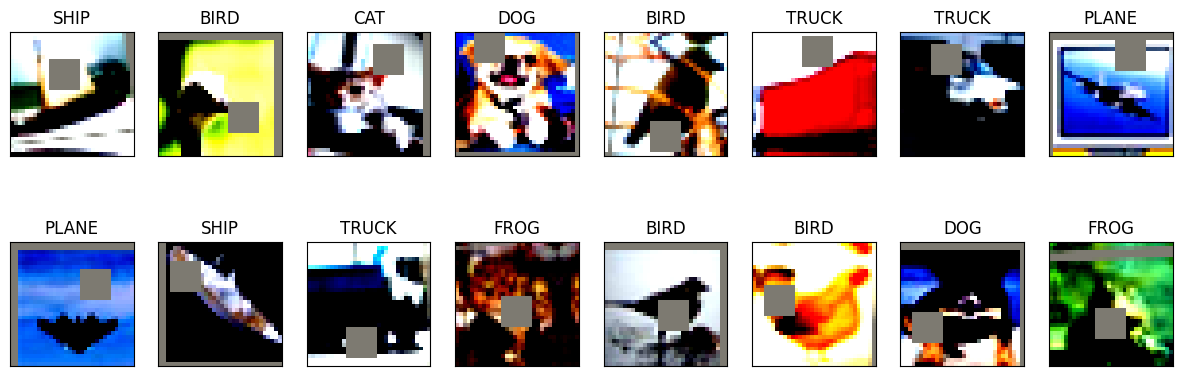

In [10]:
# We will now visualize DataSet by printing data scale and some samples
from woolly.utils.visualize import (
    print_class_scale,
    print_samples,
    print_samples_native,
)

if show_dataset_analyze:
    # print class scale
    # print_class_scale(train_loader, class_map)
    # print data samples
    # print_samples_native(train_loader, class_map)
    print_samples(train_loader, class_map)

In [11]:
# from woollylib.models.custom.custom_resnet import CustomResNet
# from woollylib.main import get_optimizer
# from torch_lr_finder import LRFinder

# # Create model instance based on parameter which one to use
# model = CustomResNet(norm=norm, ctype=ctype).to(device)
# optimizer, criteria = get_optimizer(model, lr, momentum, weight_decay, device)

# lr_finder = LRFinder(model, optimizer, criteria, device=device)
# lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=1, num_iter=100, step_mode="linear")
# lr_finder.plot(log_lr=False)
# lr_finder.reset()

In [12]:
from woolly.models.custom.custom_resnet import CustomResNet

from woolly.main import get_optimizer, get_scheduler
from woolly.utils.utils import initialize_weights, print_summary

from woolly.bp.optimizer.backpropagation import get_sgd_optimizer, get_adam_optimizer
from woolly.bp.losses.backpropagation import (
    get_crossentropy_criteria,
    get_label_smoothing_criteria,
    get_nnl_criteria,
)

from woolly.scheduler import one_cycle_lr_custom

from woolly.training import Training
from torch.cuda.amp import GradScaler

from woolly.bp.autocast.backpropagation import train, test

epochs = 24
lr = 0.045
max_lr = 0.45
steps_per_epoch = len(train_loader)
dropout = False
drop_ratio = 0.1
use_l1 = False
lambda_l1 = 1e-7
min_momentum = 0.9
momentum = 0.9
weight_decay = 0.0005
weight_decay = weight_decay  # / batch_size

norm = "bn"
ctype = "vanila"
train_function = train
test_function = test

print("Using Device:", device)
print("Epochs:", epochs)
print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("Dropout:", dropout)
print("Dropout Ratio:", drop_ratio)
print("Momentum:", momentum)
print("Weight Decay:", weight_decay)
print("Use L1:", use_l1)
print("L1 Lambda:", lambda_l1)
print("RICAP Beta", ricap_beta)


ctrain = train_function(use_l1=use_l1, lambda_l1=lambda_l1)

# Create model instance based on parameter which one to use
model = CustomResNet().to(device)

optimizer = get_sgd_optimizer(
    model, lr=lr, momentum=momentum, weight_decay=weight_decay
)
criteria = get_label_smoothing_criteria(device)

schedule = np.interp(np.arange(epochs + 1), [0, 7, epochs], [lr, max_lr, lr / 40.0])
mschedule = np.interp(
    np.arange(epochs + 1), [0, 7, epochs], [momentum, min_momentum, momentum]
)

# Create Custom One Cycle schedule instance
custom_scheduler = one_cycle_lr_custom(
    optimizer,
    lr=lr,
    max_lr=max_lr,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    lrschedule=schedule,
    mschedule=mschedule,
)

# optimizer = get_adam_optimizer(model, lr=lr, weight_decay=weight_decay)
# criteria = get_crossentropy_criteria(device)

# custom_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer,
#     max_lr,
#     # total_steps=None,
#     epochs=epochs,
#     steps_per_epoch=steps_per_epoch,
#     pct_start=0.2,
#     anneal_strategy="linear",
#     cycle_momentum=True,
#     base_momentum=0.85,
#     max_momentum=0.95,
#     div_factor=25.0,
#     final_div_factor=10000.0,
#     three_phase=False,
#     # last_epoch=-1,
#     verbose=False,
# )

scaler = GradScaler()


# Create instance of trainer with all params
trainer = Training(
    model,
    optimizer,
    criteria,
    custom_scheduler,
    ctrain,
    test_function,
    train_loader,
    test_loader,
    lr,
    epochs,
    device,
    dropout,
    scaler,
)

if show_summary:
    print_summary(model, input_size=(3, 32, 32))
#     print_modal_summary(trainer.model)

# Run trainer
trainer.run()

Using Device: cuda
Epochs: 24
Lr: 0.045
Max Lr: 0.45
Batch Size: 512
Dropout: False
Dropout Ratio: 0.1
Momentum: 0.9
Weight Decay: 0.0005
Use L1: False
L1 Lambda: 1e-07
RICAP Beta 0.4
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
          WyConv2d-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
              ReLU-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
          WyConv2d-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
       BatchNorm2d-8          [-1, 128, 16, 16]             256
            Conv2d-9          [-1, 128, 16, 16]         147,456
         WyConv2d-10          [-1, 128, 16, 16]               0
      BatchNorm2d-11          [-1, 128, 16, 16]

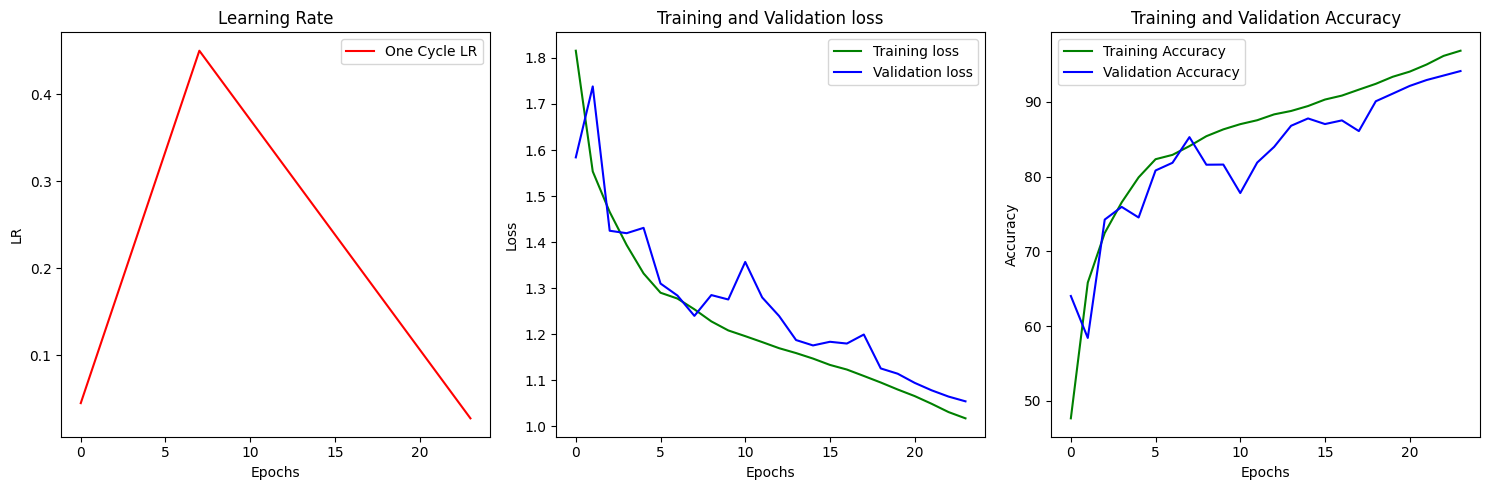

Normalized confusion matrix


Total Incorrect Predictions 588


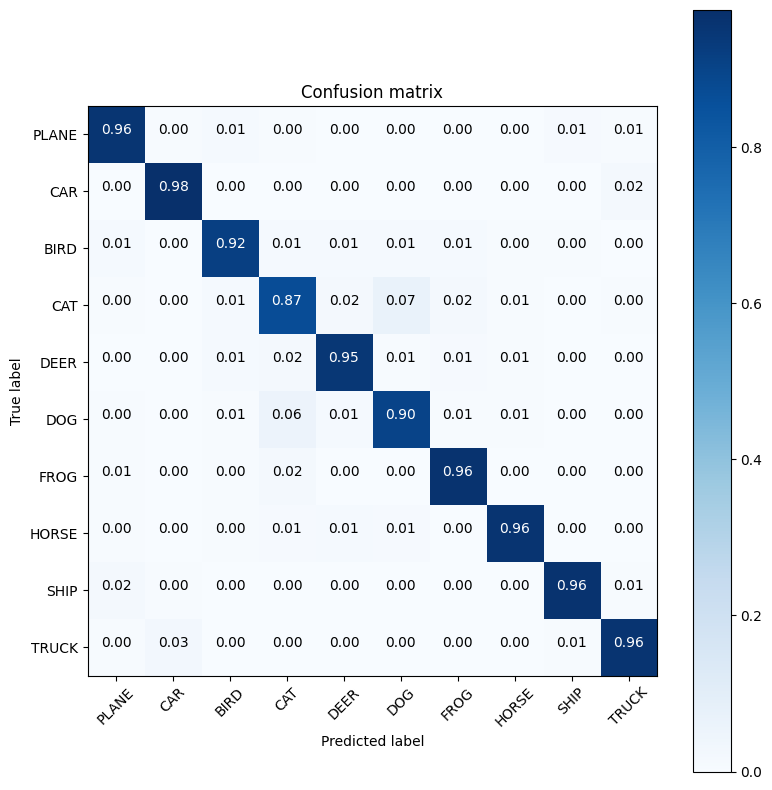

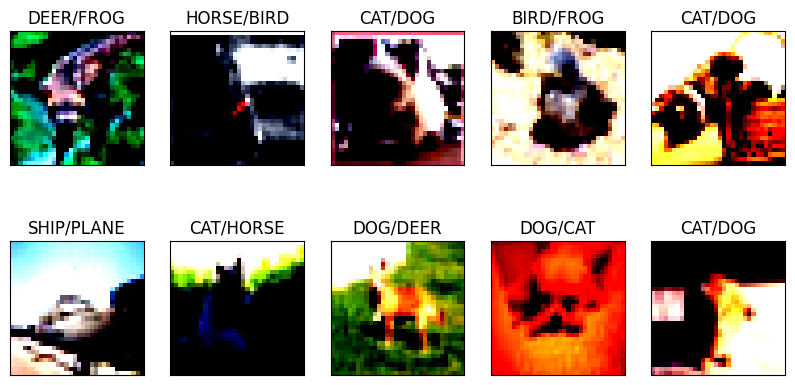

In [13]:
# Visualize network performance

from woolly.utils.visualize import plot_network_performance
from woolly.utils.utils import get_incorrrect_predictions
from woolly.utils.visualize import plot_incorrect_predictions

from woolly.utils.utils import (
    get_all_predictions,
    get_incorrrect_predictions,
    prepare_confusion_matrix,
)
from woolly.utils.visualize import plot_confusion_matrix

plot_network_performance(
    epochs,
    trainer.schedule,
    trainer.list_train_loss,
    trainer.list_valid_loss,
    trainer.list_train_correct,
    trainer.list_valid_correct,
)

all_preds, all_targets = get_all_predictions(trainer.model, test_loader, device)
confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, class_map)
plot_confusion_matrix(confusion_matrix, class_map, normalize=True)

incorrect = get_incorrrect_predictions(trainer.model, test_loader, device)
plot_incorrect_predictions(incorrect, class_map)

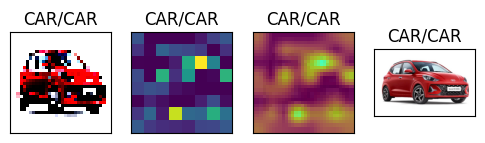

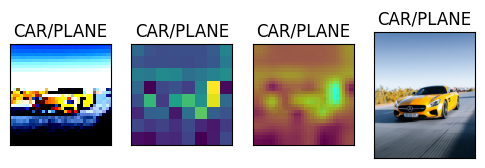

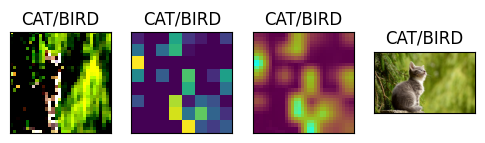

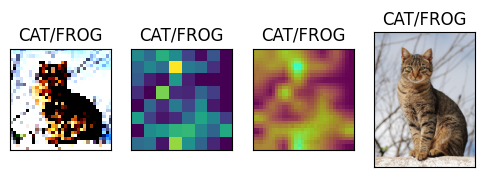

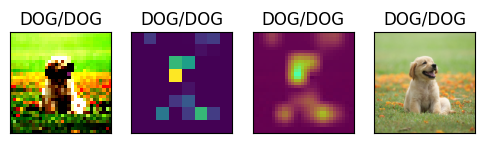

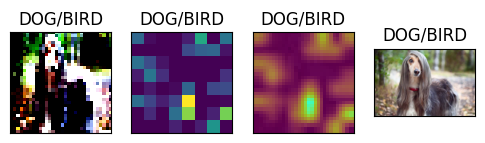

In [14]:
from woolly.utils.gradcam.compute import compute_gradcam

from torch.utils import data

from woolly.dataset.cifar.dataset import WyCustomDataset

transform = get_transform(
    {
        "resize": BASE_PROFILE["resize"],
        "normalize": BASE_PROFILE["normalize"],
        "to_tensor": BASE_PROFILE["to_tensor"],
    }
)

# define an image dataset
dataset = WyCustomDataset(class_map=class_map, path="./data", transforms=transform)

# define the data loader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

# Compute for all
for img, label, (impath,) in dataloader:
    compute_gradcam(
        trainer.model, class_map, img, impath, label, channel_size=256, device=device
    )

In [15]:
import torch

torch.onnx.export(
    model,
    img.to(device),
    "cifar_davidnet_94.12.onnx",
    input_names=["image"],
    output_names=["classes"],
)

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

